In this notebook, we try to deduce the equivalent circuit of a WEST ICRH capacitor which has been simulated under HFSS.  

In [12]:
import skrf as rf
import numpy as np
rf.stylely()

C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [37]:
capas = rf.load_all_touchstones('S_Matrices/', f_unit='MHz')
f_band = '35-65MHz'
freq = capas['WEST_ICRH_Capacitor_Dcylinders100mm'].frequency

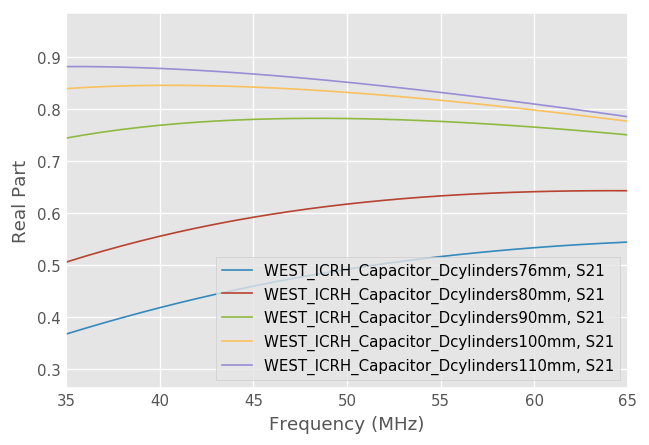

In [26]:
capas['WEST_ICRH_Capacitor_Dcylinders76mm'][f_band].plot_s_re(m=1, n=0)
capas['WEST_ICRH_Capacitor_Dcylinders80mm'][f_band].plot_s_re(m=1, n=0)
capas['WEST_ICRH_Capacitor_Dcylinders90mm'][f_band].plot_s_re(m=1, n=0)
capas['WEST_ICRH_Capacitor_Dcylinders100mm'][f_band].plot_s_re(m=1, n=0)
capas['WEST_ICRH_Capacitor_Dcylinders110mm'][f_band].plot_s_re(m=1, n=0)

Create a serie capacitor

In [44]:
coax = rf.media.Coaxial(frequency=freq, Dint=30e-2, Dout=40e-2)
coax

Coaxial Transmission Line.  1-100 MHz.  100 points
Dint= 300.00 mm, Dout= 400.00 mm 
Characteristic Impedance=(17.2,-0.0j)-(17.2,-0.0j) Ohm
Port impedance Z0=(17.2,-0.0j)-(17.2,-0.0j) Ohm

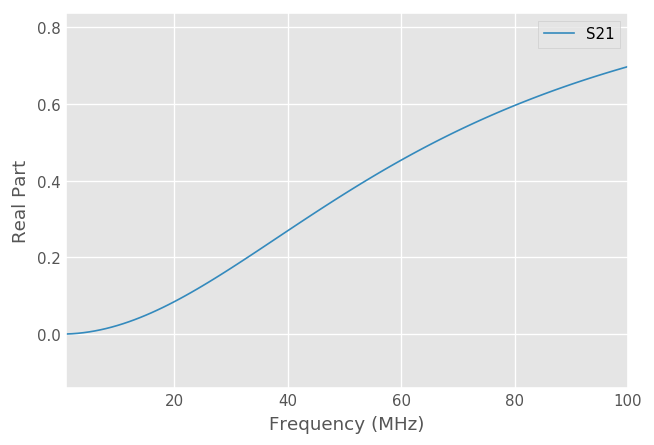

In [45]:
coax.capacitor(70e-12).plot_s_re(m=1, n=0)